<font color=White size=5 face=雅黑>2  Reinforcement Learning</font>

(a) Please follow the algorithm shown below and use ϵ-greedy policy to implement the
DQN. (show the result movie)

In [1]:
import gym
import random
import torch
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
env = gym.make("LunarLander-v2")
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of Actions: ', env.action_space.n)

State shape:  (8,)
Number of Actions:  4


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt
class QNet(nn.Module):
    def __init__(self, state_size, action_size,  fc1_units=64, fc2_units=64):

        
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

# Use GPU is possible else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DQN():
    def __init__(self, state_size, action_size, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # model
        self.net_local= QNet(state_size, action_size).to(device)
        self.net_target = QNet(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.net_local.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(action_size, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_local.eval()
        with torch.no_grad():
            action_values = self.net_local(state)
        self.net_local.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.action_size))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_local(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_local.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)

In [4]:
class ReplayBuffer():
    def __init__(self, action_size, memory_size, batch_size):
        self.action_size = action_size
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

In [16]:
def train(env, agent, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200, chkpt=True):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # if (idx_epi+1) % 100 == 0:
        #     print(" ")
        #     sleep(0.1)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")
        
    if chkpt:
        torch.save(agent.net_local.state_dict(), 'checkpoint.pth')

    return score_hist

In [6]:
#%% Test Lunar Lander
def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

In [9]:
BATCH_SIZE = 128
LR = 1e-3
EPISODES = 5000
TARGET_SCORE = 210.     # 如果達到標準提早結束training
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # buffer size最大容量
LEARN_STEP = 5          # learn的頻率
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = True      # 儲存.pth檔

 31%|###1      | 1556/5000 [  27:17<1:00:24,  1.05s/ep, Score:  268.30, 100 score avg:  210.24]


Target Reached!


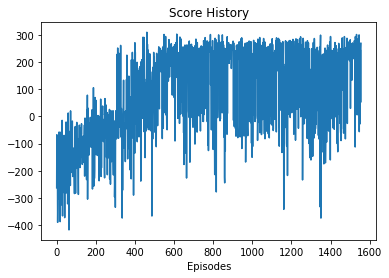

In [10]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    state_size = num_states,
    action_size = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    )
score_hist = train(env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
plotScore(score_hist)


In [26]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
agent.net_local.state_dict(torch.load('checkpoint.pth'))
for i in range(3):
    state = env.reset()
    video_recorder = None
    video_recorder = VideoRecorder(env, './video.mp4', enabled=True)
    for j in range(500):
        action = agent.getAction(state,epsilon=0)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break

env.close()


In [ ]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

def TextOnImg(img, score):
    img = Image.fromarray(img)
    font = ImageFont.truetype('/Library/Fonts/arial.ttf', 18)
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), f"Score={score: .2f}", font=font, fill=(255, 255, 255))

    return np.array(img)

def save_frames_as_gif(frames, filename, path="gifs/"):
    if not os.path.exists(path):
        os.makedirs(path)
        
    print("Saving gif...", end="")
    imageio.mimsave(path + filename + ".gif", frames, fps=60)

    print("Done!")

def gym2gif(env, agent, filename="gym_animation", loop=3):
    frames = []
    for i in range(loop):
        state = env.reset()
        score = 0
        for idx_step in range(500):
            frame = env.render(mode="rgb_array")
            frames.append(TextOnImg(frame, score))
            action = agent.getAction(state, epsilon=0)
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                break
    env.close()
    save_frames_as_gif(frames, filename=filename)

gym2gif(env, agent, loop=5)

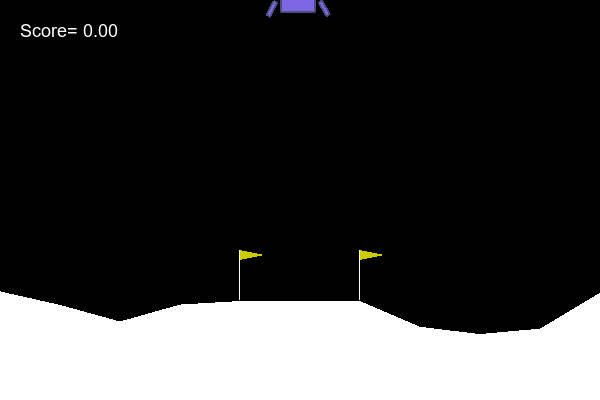

In [29]:
from IPython.display import Image
Image(filename='target250.gif')


'<img src="/gamma09.gif;base64,{0}"/>'.format(base64.b64encode(gif))

(b) Please choose some hyper-parameters about collecting and using trajectories and analyze how these hyper-parameters affect the training result or training time. 

A:因為一開始設定episode數量時沒有頭緒，而跑了幾次觀察圖形規律後，決定設一個target score以節省時間，而我發現若是target score射的較小，雖然可以較短時間train完，但在demo時失誤的機率較大，而taget score設高一點能確保demo時較少失誤發生。而改變Discount factor也就是GAMMA時，我發現gamma超過1時training curve反而會下降，代表訓練發散了，應該是跟V或Q的公式有關。還有改變buffer size也會影響學習的過程，越大的buffer size也就代表有越多的經驗能夠replay，也表示能避免都學到相關的訊息，但也連帶占用更多的記憶體，training速度變慢，這也是調整參數的trade-off。